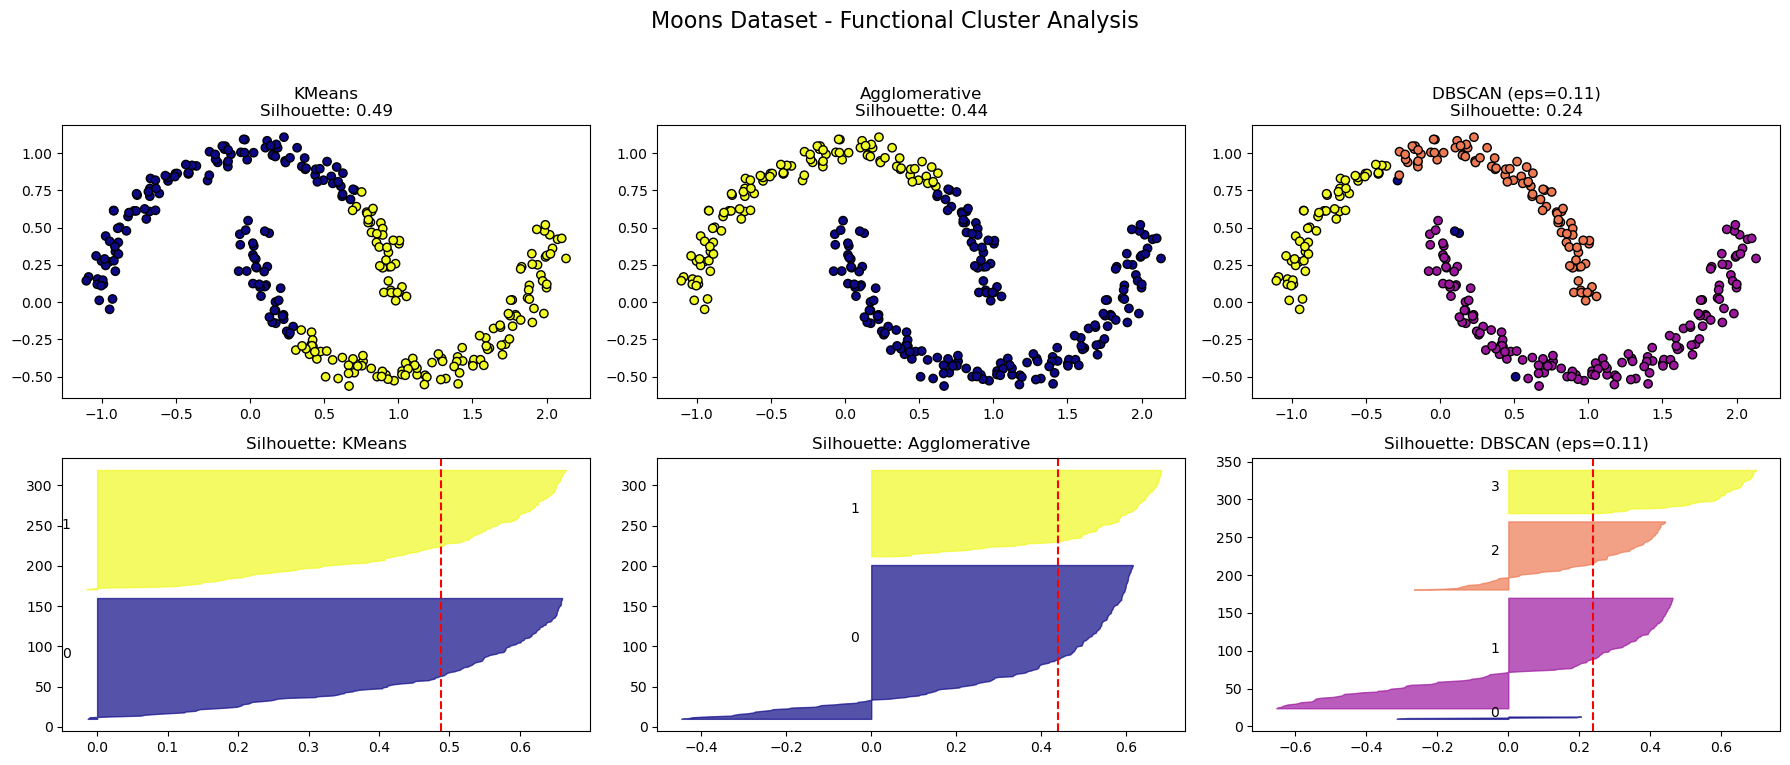

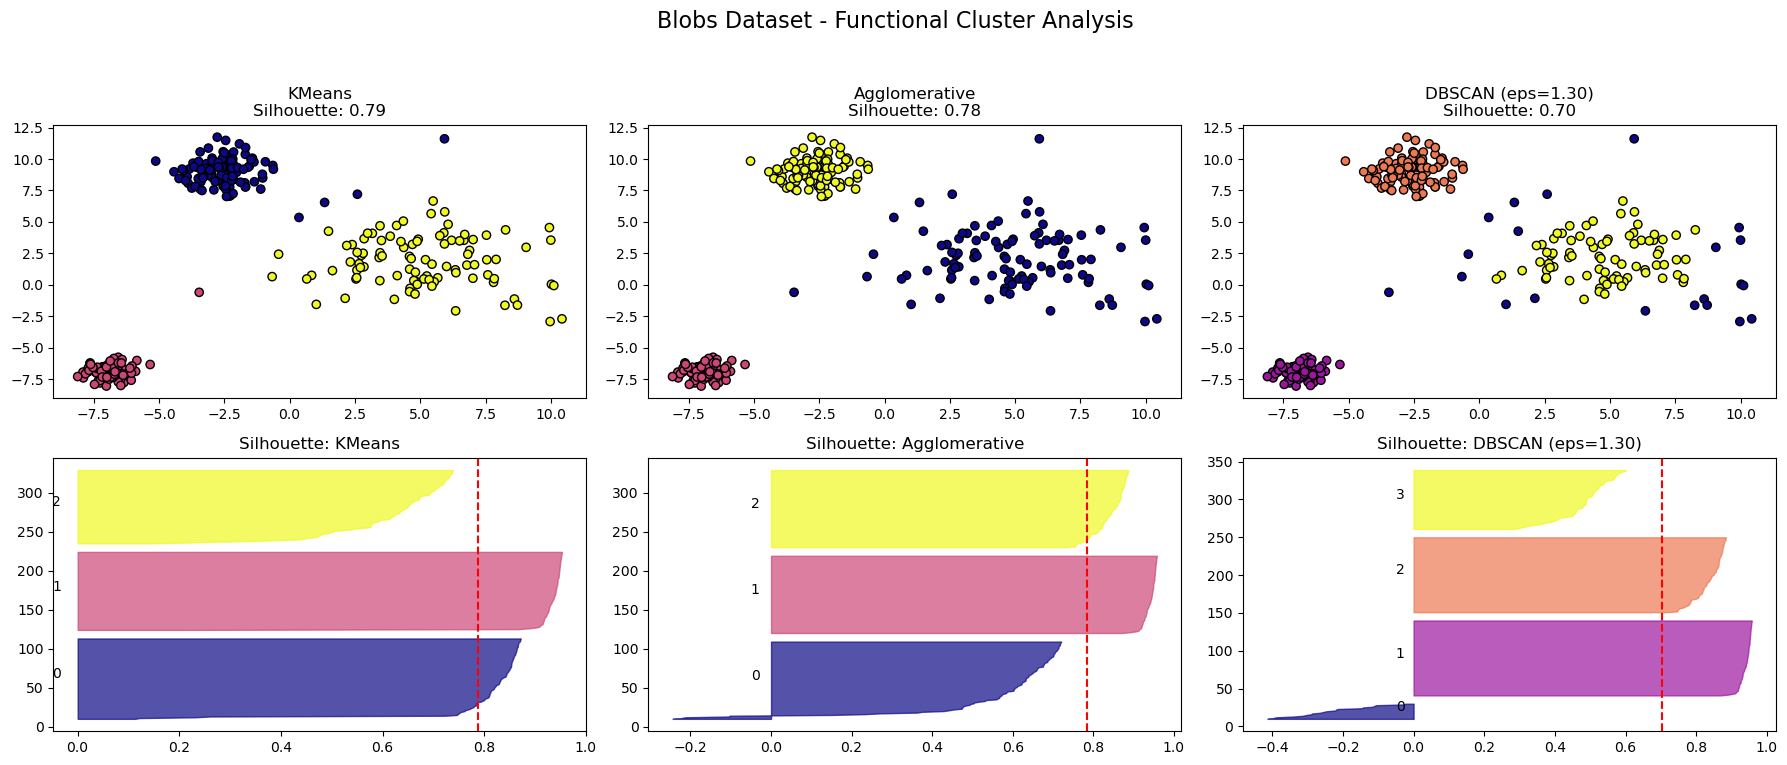

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from matplotlib.colors import ListedColormap
from matplotlib import cm

# --- Dataset functions ---
def generate_dataset(kind):
    if kind == "moons":
        return make_moons(n_samples=300, noise=0.05, random_state=42)
    elif kind == "blobs":
        return make_blobs(n_samples=300, centers=3, cluster_std=[1.0, 2.5, 0.5], random_state=42)
    else:
        raise ValueError("Unknown dataset kind.")

# --- Clustering strategy functions ---
def estimate_eps(X, min_samples=5):
    dists, _ = NearestNeighbors(n_neighbors=min_samples).fit(X).kneighbors(X)
    return np.percentile(np.sort(dists[:, -1]), 90)

def get_models(X, dataset_name):
    k = 2 if dataset_name == "moons" else 3
    eps = estimate_eps(X)
    return {
        "KMeans": lambda: KMeans(n_clusters=k, random_state=42),
        "Agglomerative": lambda: AgglomerativeClustering(n_clusters=k),
        f"DBSCAN (eps={eps:.2f})": lambda: DBSCAN(eps=eps, min_samples=5)
    }

# --- Visualization ---
from matplotlib.colors import Normalize

def remap_labels(labels):
    uniq = np.unique(labels)
    mapping = {label: i for i, label in enumerate(uniq)}
    remapped = np.array([mapping[l] for l in labels])
    
    # Use a perceptually uniform colormap like 'plasma'
    norm = Normalize(vmin=0, vmax=len(uniq) - 1)
    colors = cm.plasma(norm(np.arange(len(uniq))))
    cmap = ListedColormap(colors)
    
    return remapped, cmap


def plot_clusters_and_silhouette(X, labels, title, axes):
    ax_cluster, ax_sil = axes
    remapped, cmap = remap_labels(labels)
    score = silhouette_score(X, labels) if len(set(labels)) > 1 else None

    # Cluster scatter plot
    ax_cluster.scatter(X[:, 0], X[:, 1], c=remapped, cmap=cmap, edgecolor='k')
    ax_cluster.set_title(f"{title}\nSilhouette: {score:.2f}" if score else f"{title}\nInvalid")

    # Silhouette plot
    if score is None:
        ax_sil.text(0.5, 0.5, 'Not enough clusters', ha='center', va='center')
        ax_sil.axis('off')
        return

    sil_vals = silhouette_samples(X, labels)
    y_lower = 10
    for i, label in enumerate(np.unique(remapped)):
        v = np.sort(sil_vals[remapped == label])
        y_upper = y_lower + len(v)
        ax_sil.fill_betweenx(np.arange(y_lower, y_upper), 0, v,
                             facecolor=cmap(i), edgecolor=cmap(i), alpha=0.7)
        ax_sil.text(-0.05, y_lower + len(v) / 2, str(label))
        y_lower = y_upper + 10
    ax_sil.axvline(x=score, color="red", linestyle="--")
    ax_sil.set_title(f"Silhouette: {title}")

# --- Pipeline Orchestration ---
def run_pipeline(dataset_name):
    X, _ = generate_dataset(dataset_name)
    models = get_models(X, dataset_name)

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    for i, (name, model_factory) in enumerate(models.items()):
        model = model_factory()
        labels = model.fit_predict(X)
        plot_clusters_and_silhouette(X, labels, name, (axes[0, i], axes[1, i]))

    fig.suptitle(f"{dataset_name.capitalize()} Dataset - Functional Cluster Analysis", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run for both datasets
for ds in ["moons", "blobs"]:
    run_pipeline(ds)
